In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, LayerType, SamplingMethod, System, OptimizerType, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## basic

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 20,
 "lr": 10,
 "loss_log_interval": 1,
 "optimizer_type": "AdamW",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variab

D:\UofT\Research\PDE-work\continuous-time-eco-models\deep_macrofin\models\kan\KAN.py:329: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


====================================Training====================================


Total loss: 0.0003: 100%|██████████| 20/20 [02:26<00:00,  7.30s/it]


training finished, total time :: 146.07920289039612
Best model saved to ./models/BruSan14_log_utility_kan/model_best.pt if valid
Model saved to ./models/BruSan14_log_utility_kan/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0003,
endogeq_2: 0.0000,
total_loss: 0.0003


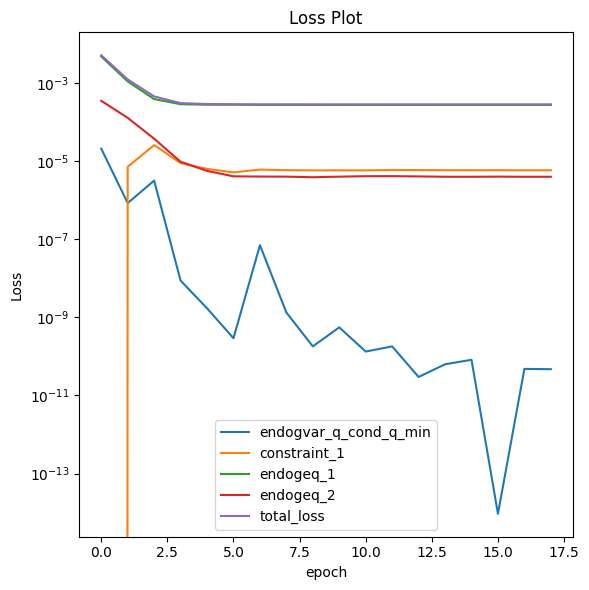

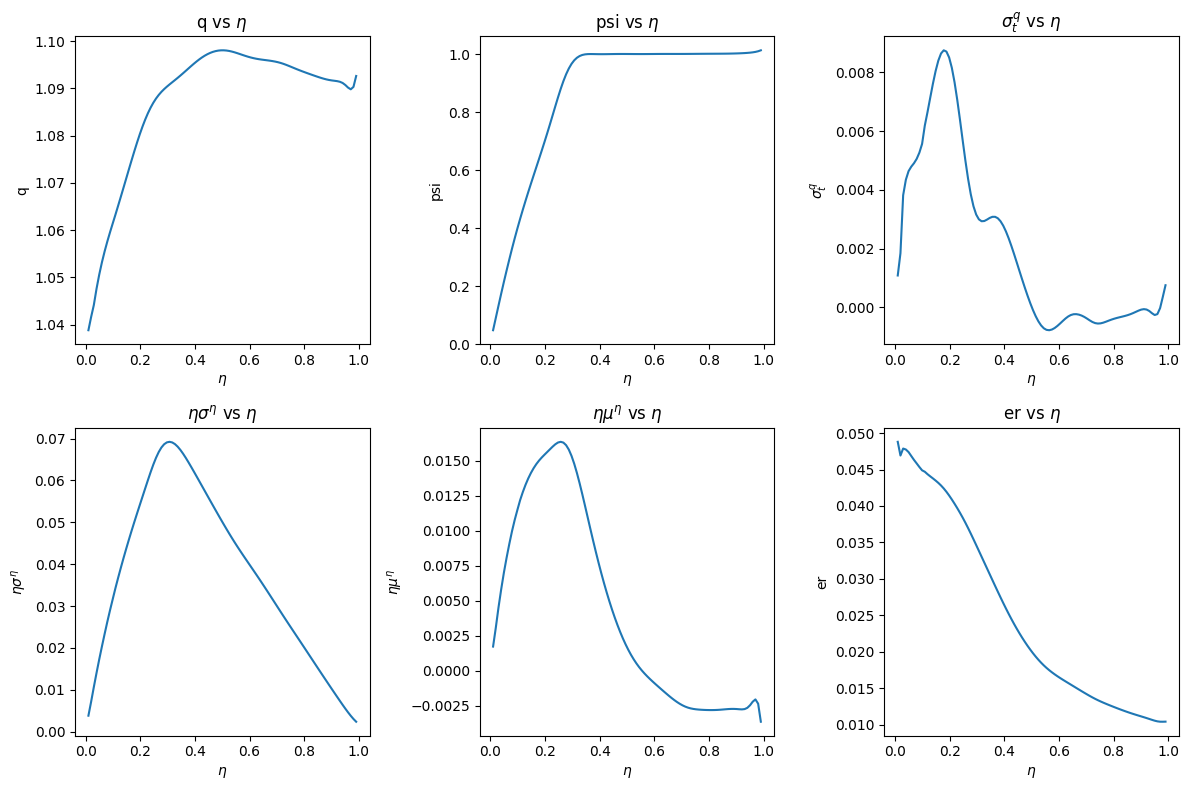

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid,
    "num_epochs": 20, "loss_log_interval": 1, "lr": 10}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "layer_type": LayerType.KAN,
        "hidden_units": [1, 5, 5, 1], 
        "activation_type": ActivationType.ReLU,
        "grid": 20,
        "k": 5,
    },
    "psi": {
        "positive": True, 
        "layer_type": LayerType.KAN,
        "hidden_units": [1, 5, 5, 1], 
        "activation_type": ActivationType.ReLU,
        "grid": 20,
        "k": 5,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_kan/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_kan", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_kan/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_kan/model_best.pt"))
    pde_model.eval_model(True)
plot_loss_df(fn="./models/BruSan14_log_utility_kan/model_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility_kan/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)